# Imports

In [1]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
import tqdm
from transformers import TFAutoModelForSequenceClassification, pipeline

# Data
Web scraping

In [2]:
# define chrome driver
driver = webdriver.Chrome(ChromeDriverManager().install())

site='https://www.gutenberg.org/ebooks/2600'

# open site that contains book
driver.get(site)

C:\Users\mmtom\AppData\Local\Temp\ipykernel_19984\2312541311.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [3]:
# link to the book in txt format has 'type' attribute inside 'a' tag defined as 'text/plain'
driver.find_element(By.XPATH, "//a[@type='text/plain']").click()

In [4]:
# book contents are located inside 'pre' tag
text = driver.find_element(By.XPATH, "//pre").text
# close driver
driver.quit()

# Data preparation
Text cleaning and formatting

In [5]:
# remove newline characters and replace them with spaces
text = text.replace('\n', ' ')

# find beginning index of the book
book_beginning = re.search(r'BOOK ONE: \d{,4}(?= ).{,10}CHAPTER I.{,10}“Well, Prince', text)
# find ending index of the book
book_end = re.search(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE', text)

# remove redundant text
text = text[book_beginning.span()[0]:book_end.span()[0]]

In [6]:
def divider(txt: str, is_book: bool) -> dict:
    """
    Divides text into books or chapters

    Args:
        txt: Text that is to be divided into chapters/books
        is_book: Param to define split into books or chapters

    Returns:
        dictionary: Dictionary with chapter/book name as keys and given chapter/book contents as value
    """
    # define query to search books or chapters
    if is_book:
        # epilogues are defined as books
        query = r'(BOOK .*?(?=:): \d{,5}(?= )( - \d{,2}(?= ))?)|([A-Z]{,6} EPILOGUE:?( \d{,5}(?= )( - \d{,2}(?= )))?)'
    else:
        query = r'CHAPTER [A-Z]*(?= )'

    divided_text = {}
    last_item = None
    # reversing the list for easier book/chapter extraction
    for item in list(re.finditer(query, txt))[::-1]:
        if not last_item:
            # first item is last book/chapter, so it ends at the end of txt param
            end = len(txt)
            last_item = item
        else:
            # items (except first) point to book/chapter that ends at the start of previous item
            end = last_item.start()
            last_item = item

        item_name = txt[item.start():item.end()]
        divided_text[item_name] = txt[item.end():end]
    # reversing contents to original order
    return dict(reversed(list(divided_text.items())))

In [7]:
divided_book = {}
# divide text into books
books = divider(text, True)
for book in books.keys():
    # divide books into chapters
    divided_book[book] = divider(books[book], False)

In [8]:
# get english stop words
stop_words = set(stopwords.words('english'))
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [9]:
def get_wordnet_pos(treebank_tag):
    """
    Function from seminar files used to get word part-of-speech
    Args:
        treebank_tag: word PoS tag

    Returns:
        string: wordnet word PoS classification
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.VERB

In [10]:
# get book tokens
tokens_dict = {}
for book_name, chapters_dict in divided_book.items():
    # create dict for every book
    tokens_dict[book_name] = {}
    for chapter_name, chapter_content in chapters_dict.items():
        sents = []
        try:
            # replace symbols that were found to be ignored by tokenizer
            chapter_content = chapter_content.replace('—', ' ')
            chapter_content = chapter_content.replace('-', ' ')
            # divide chapter into sentences
            sent = sent_tokenize(chapter_content)
            sents.append(sent)
        except:
            # pass if chapter_content cannot be divided into sentences
            pass

        sents = [sent for sublist in sents for sent in sublist]
        # divide sents into tokens
        sents = [word_tokenize(sent) for sent in sents]
        # remove tokens shorter than one symbol
        sents = [[token for token in sent] for sent in sents if len(sent)>1]
        # remove tokens that aren't words and make all characters lowercase
        sents = [[token.lower() for token in sent if re.search(r'\w+|\d', token)] for sent in sents]
        # remove stopwords
        sents = [[token for token in sent if token not in stop_words] for sent in sents]

        # find bigrams
        bigram_transformer = Phrases(sents, connector_words=ENGLISH_CONNECTOR_WORDS, min_count=10)
        # add bigrams to token list
        sents = [bigram_transformer[sent] for sent in sents]
        # find words PoS tag
        sents_pos =[nltk.pos_tag(sent) for sent in sents]
        # lemmatize tokens
        sents_lem = [[lemmatizer.lemmatize(token[0], pos=get_wordnet_pos(token[1])) for token in sent] for sent in sents_pos]
        chapter_sents = [sent for sent in sents_lem if len(sent)>1]
        # assign tokens to given chapter
        tokens_dict[book_name][chapter_name] = chapter_sents

In [11]:
# get every token divided into sentences in book
sents_in_books = [[book_tokens for _, chapters in book.items() for book_tokens in chapters] for _, book in tokens_dict.items()]

In [12]:
# get text divided by chapter
text_by_chapter = [chapter_contents for _, book_contents in divided_book.items() for _, chapter_contents in book_contents.items()]
# get every non-tokenized sentence
sents_by_chapter = [sent_tokenize(chapter_contents) for _, book_contents in divided_book.items() for _, chapter_contents in book_contents.items()]

In [13]:
sents = [sent for chapter in sents_in_books for sent in chapter]

In [14]:
# get all tokens
tokens = [tokens_list for _, chapter_list in tokens_dict.items() for _, tokens_list in chapter_list.items()]

In [15]:
tokens = [[token for sent in chapter for token in sent] for chapter in tokens]

In [16]:
# create token dictionary
dictionary = Dictionary(tokens)
# filter extremes
dictionary.filter_extremes(no_below=20, no_above=0.5)

# create corpus
corpus = [dictionary.doc2bow(chapter) for chapter in tokens]

In [17]:
# get book token count
token_count = len([token for sent in tokens for token in sent])
tf_most_common = []

# calculate term frequency of most common tokens
for word, count in dictionary.most_common():
    tf_most_common.append((word, count/token_count))

# Data analysis

#### Token frequency

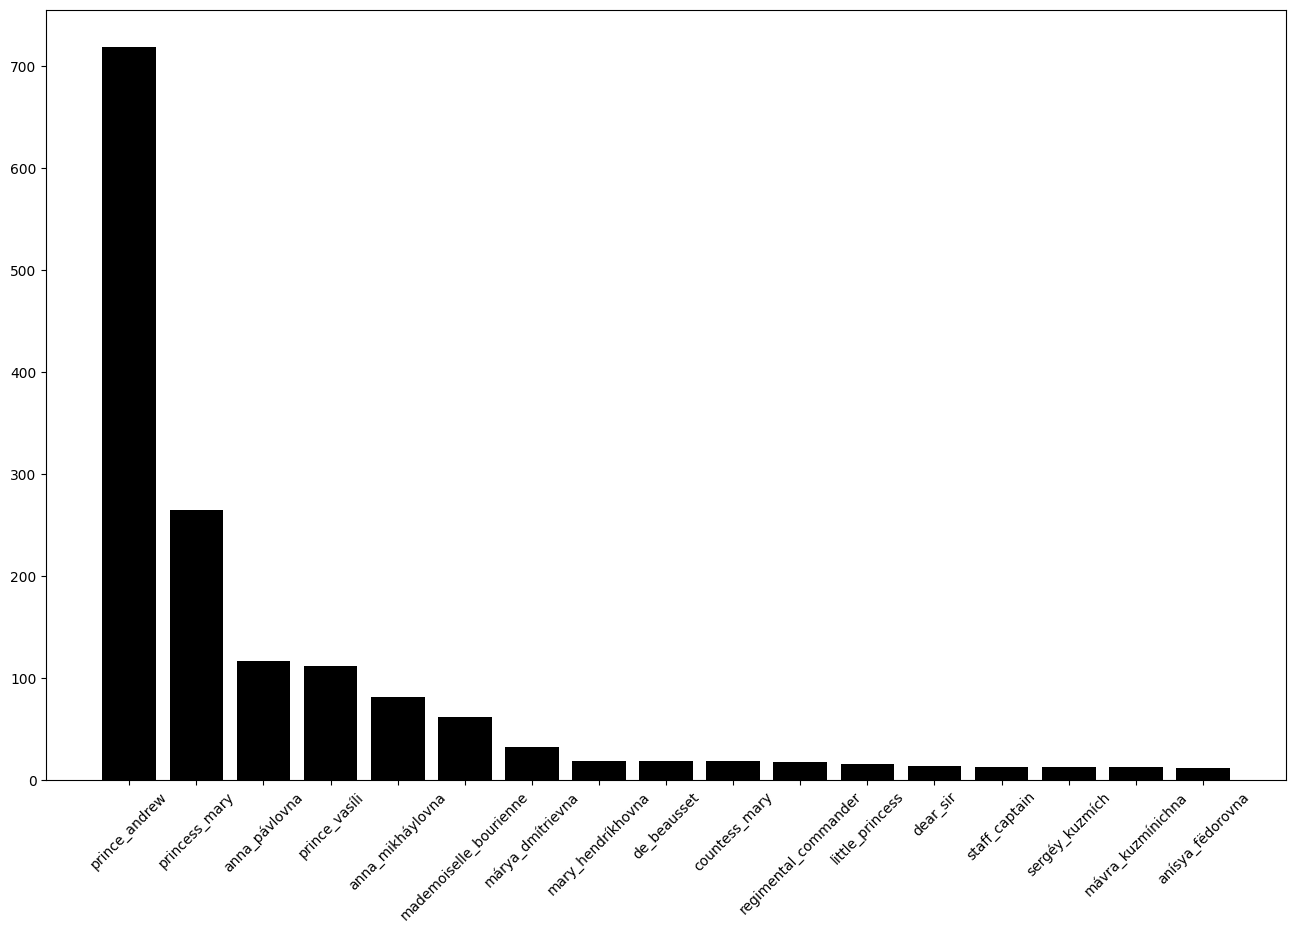

In [18]:
# get most common bigrams present in book
bigrams = Counter([token for sent in sents for token in sent])
bigrams =  list(bigrams.most_common())
bigrams = [item for item in bigrams if '_' in item[0]]

# plot bigram count
fig = plt.figure(figsize=(16,10))
plt.bar([row[0] for row in bigrams],[row[1] for row in bigrams], color='black')
plt.xticks(rotation = 45)
# plt.savefig('bigrams.png')
plt.show()

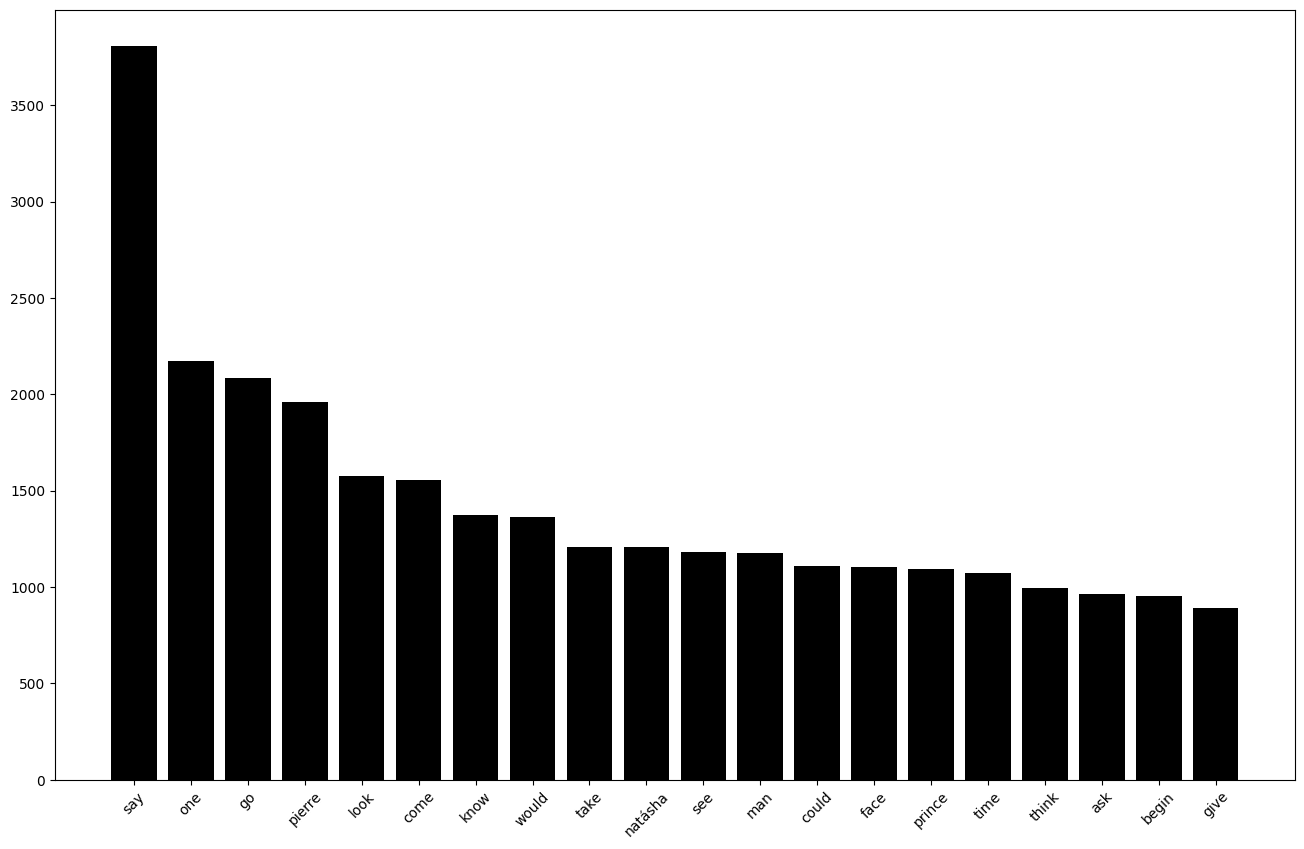

In [19]:
# get 20 most common tokens (without extremes filtering)
token_count_unfiltered = Counter([token for sent in sents for token in sent])
token_count_unfiltered = list(token_count_unfiltered.most_common(20))

# plot unfiltered token count
fig = plt.figure(figsize=(16,10))
plt.bar([row[0] for row in token_count_unfiltered],[row[1] for row in token_count_unfiltered], color='black')
plt.xticks(rotation = 45)
# plt.savefig('token_unf.png')
plt.show()

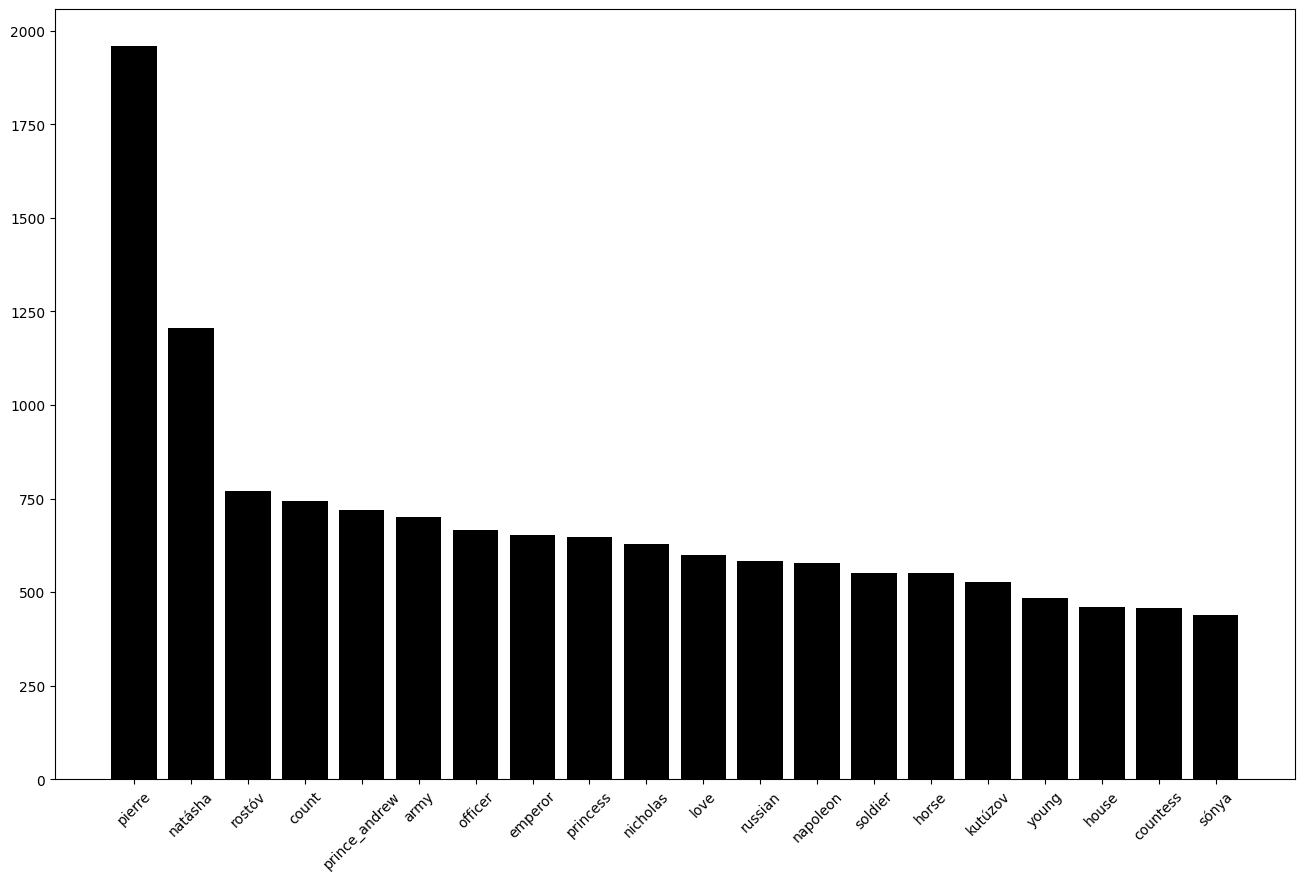

In [20]:
# get 20 filtered most common token count
token_count_filtered = dictionary.most_common(20)

# plot filtered most common tokens values
fig = plt.figure(figsize=(16,10))
plt.bar([row[0] for row in token_count_filtered],[row[1] for row in token_count_filtered], color='black')
plt.xticks(rotation = 45)
# plt.savefig('token_filt.png')
plt.show()

#### Word2Vec model

In [21]:
# create Word2Vec model
# define model specification
num_features = 60
min_word_count = 3
num_workers = 8
window_size = 6
epochs=30

# create model
W2Vmodel = Word2Vec(sents,
                 workers=num_workers,
                 vector_size=num_features,
                 min_count=min_word_count,
                 window=window_size,
                 epochs=epochs,
                 seed=1234)

In [22]:
W2Vmodel.wv.most_similar('count')

[('orël', 0.47783881425857544),
 ('vladímirovich', 0.46413010358810425),
 ('schoolroom', 0.46159714460372925),
 ('ilyá', 0.44532981514930725),
 ('fóka', 0.4403909146785736),
 ('countess', 0.43798020482063293),
 ('broadsheet', 0.43514320254325867),
 ('shinshín', 0.43210530281066895),
 ('nataly', 0.4289258122444153),
 ('vasílyevich', 0.4252162575721741)]

In [23]:
W2Vmodel.wv.most_similar('napoleon')

[('emperor', 0.6261329650878906),
 ('thiers', 0.571002721786499),
 ('duke', 0.556919276714325),
 ('prussia', 0.5552513003349304),
 ('alexander', 0.5527060627937317),
 ('bourbon', 0.5507513880729675),
 ('murat', 0.5407450795173645),
 ('interpreter', 0.5252305865287781),
 ('tsar', 0.5215849280357361),
 ('balashëv', 0.51560378074646)]

In [24]:
W2Vmodel.wv.most_similar(positive=['pierre', 'natásha'])

[('sónya', 0.6344700455665588),
 ('princess_mary', 0.6055651307106018),
 ('berg', 0.5729446411132812),
 ('prince_vasíli', 0.5714232921600342),
 ('anatole', 0.546126663684845),
 ('distress', 0.5403686165809631),
 ('quietly', 0.5359490513801575),
 ('countess', 0.5330123901367188),
 ('newcomer', 0.5269787311553955),
 ('husband', 0.5260291695594788)]

#### LDA model

In [25]:
id2word = dictionary.id2token

def compute_coherence_values(corpus, k, a, b):
    """
    Function from seminar files used to compute coherence value for given number of topics
    Args:
        corpus: dictionary corpus
        k: number of topics
        a: model alpha
        b: model eta

    Returns:
        float: coherence value
    """
    lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=k,
                         random_state=100,
                         chunksize=2500,
                         alpha=a,
                         eta=b,
                         passes=2,
                         per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [26]:
## Function from seminar used to get coherence value data for given topic number range

## define the number of topics

min_topics = 5
max_topics = 15
step_size = 1

# create topic range
topics_range = range(min_topics, max_topics, step_size)

num_of_docs = len(corpus)
corpus_sets = [corpus]

model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                 }

alpha = ['symmetric']
beta = ['symmetric']


pbar = tqdm.tqdm(total=len(corpus_sets)*len(topics_range)*len(alpha)*len(beta))

for i in range(len(corpus_sets)):
    for k in topics_range:
        for a in alpha:
            for b in beta:

                cv = compute_coherence_values(corpus=corpus_sets[i],
                                                k=k, a=a, b=b)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pbar.update(1)
pbar.close()
model_results=pd.DataFrame(model_results)

100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


In [27]:
# print coherence value analysis results
model_results

,Topics,Alpha,Beta,Coherence
0,5,symmetric,symmetric,0.336049
1,6,symmetric,symmetric,0.309366
2,7,symmetric,symmetric,0.331147
3,8,symmetric,symmetric,0.368873
4,9,symmetric,symmetric,0.354093
5,10,symmetric,symmetric,0.351057
6,11,symmetric,symmetric,0.367837
7,12,symmetric,symmetric,0.377011
8,13,symmetric,symmetric,0.355794
9,14,symmetric,symmetric,0.370263


In [28]:
# get number of topics with the highest coherence value
model_results.iloc[model_results['Coherence'].idxmax()]

Topics              12
Alpha        symmetric
Beta         symmetric
Coherence     0.377011
Name: 7, dtype: object

In [29]:
# define number of topics
num_topics = 12

# create LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    eta='symmetric',
random_state=2018)

In [30]:
# print LDA model topics
lda_model.print_topics()

[(0,
  '0.010*"pierre" + 0.009*"officer" + 0.008*"natásha" + 0.007*"rostóv" + 0.006*"sónya" + 0.005*"princess" + 0.005*"denísov" + 0.005*"russian" + 0.005*"army" + 0.005*"soldier"'),
 (1,
  '0.008*"pierre" + 0.007*"princess" + 0.007*"soldier" + 0.006*"army" + 0.005*"natásha" + 0.005*"officer" + 0.005*"horse" + 0.005*"napoleon" + 0.005*"father" + 0.005*"russian"'),
 (2,
  '0.015*"pierre" + 0.009*"rostóv" + 0.006*"soldier" + 0.005*"natásha" + 0.005*"denísov" + 0.005*"count" + 0.005*"horse" + 0.005*"prince_andrew" + 0.005*"house" + 0.005*"officer"'),
 (3,
  '0.020*"natásha" + 0.009*"pierre" + 0.008*"countess" + 0.007*"nicholas" + 0.005*"love" + 0.005*"count" + 0.004*"russian" + 0.004*"sónya" + 0.004*"father" + 0.004*"army"'),
 (4,
  '0.014*"emperor" + 0.013*"rostóv" + 0.008*"army" + 0.007*"kutúzov" + 0.006*"natásha" + 0.005*"prince_andrew" + 0.005*"pierre" + 0.005*"officer" + 0.005*"horse" + 0.005*"count"'),
 (5,
  '0.014*"pierre" + 0.008*"napoleon" + 0.008*"prince_andrew" + 0.008*"natásh

In [31]:
for i in range(0,num_topics):
    text = {word: value for word, value in lda_model.show_topic(i)}
    wc = WordCloud(background_color="white", max_words=20)
    wc.generate_from_frequencies(text)
    plt.imshow(wc)
    plt.axis("off")
    title = "Topic {}".format(i+1)
    plt.title(title, loc='right')
    plt.savefig('wordclouts/{}.png'.format(title))
    plt.close()

C:\Users\mmtom\OneDrive\Pulpit\projects\python\REUTERS_SCRAPER\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\mmtom\OneDrive\Pulpit\projects\python\REUTERS_SCRAPER\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\mmtom\OneDrive\Pulpit\projects\python\REUTERS_SCRAPER\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use `

In [32]:
# create interactive topic visualisation
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# # save output to .html file
# pyLDAvis.save_html(vis, 'output.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.009320 -0.002526       1        1  18.465411
0     -0.002703  0.010114       2        1  15.009336
8      0.009883 -0.001829       3        1  11.719057
4     -0.012326  0.004700       4        1   9.808400
2      0.001163  0.006371       5        1   8.789632
9     -0.013428 -0.006093       6        1   8.787188
5     -0.003465 -0.010179       7        1   7.808916
11     0.002323 -0.010179       8        1   6.481213
3      0.012238  0.004922       9        1   4.461555
7      0.003923 -0.001922      10        1   3.457924
10    -0.001971  0.002061      11        1   2.979990
1     -0.004957  0.004559      12        1   2.231378, topic_info=               Term         Freq        Total Category  logprob  loglift
1031        natásha  1185.000000  1185.000000  Default  30.0000  30.0000
396          pierre  1986.000000  1986.000000  Default  29.0000  29.0000
1363        soldier   502.000000   502.000000  Default  28.0000  28.0000
90          emperor   655.000000   655.000000  Default  27.0000  27.0000
1058         rostóv   789.000000   789.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
858   prince_andrew    12.276514   696.616115  Topic12  -5.5427  -0.2360
60            count    12.315808   725.903456  Topic12  -5.5395  -0.2740
722             run     8.553657   391.544008  Topic12  -5.9040  -0.0212
1436        denísov     8.734010   449.062977  Topic12  -5.8832  -0.1374
265              us     8.335432   424.992137  Topic12  -5.9299  -0.1290

[822 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1202      1  0.128349      2
1202      2  0.102679      2
1202      3  0.102679      2
1202      4  0.102679      2
1202      5  0.102679      2
...     ...       ...    ...
281       8  0.046602  young
281       9  0.033010  young
281      10  0.025243  young
281      11  0.025243  young
281      12  0.015534  young

[5275 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 9, 5, 3, 10, 6, 12, 4, 8, 11, 2])

#### Emotion and sentiment analysis

In [33]:
text_by_book = {}
for book_name, book_contents in divided_book.items():
    text_by_book[book_name] = []
    for chapter_name, chapter_text in book_contents.items():
        text_by_book[book_name] = text_by_book[book_name] + sent_tokenize(chapter_text)

In [74]:
# define used model
emotion_model_name = 'jitesh/emotion-english'
# create model
emotion_model = TFAutoModelForSequenceClassification.from_pretrained(emotion_model_name, from_pt=True)
emotion_classifier = pipeline("text-classification", model=emotion_model, tokenizer=emotion_model_name)

results_emotion = {}
# start progress visualisation
pbar = tqdm.tqdm(total=len(text_by_book))

for book_name,text in text_by_book.items():
    # predict emotions in sentence set
    prediction = emotion_classifier(text)
    # append results
    results_emotion[book_name] = prediction
    pbar.update(1)
# close progress visualisation
pbar.close()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
100%|██████████| 17/17 [1:02:29<00:00, 220.58s/it]


In [95]:
emotion_by_book = {}
# get emotion analysis results by book
for book_name, results in results_emotion.items():
    emotion_by_book[book_name] = [item['label'] for item in results]

In [116]:
fig = plt.figure(figsize=(16,10))
# get top 5 emotions in every book
emotions_top_five = {k:Counter(v).most_common(5) for (k,v) in emotion_by_book.items()}
# create box plot for every book top 5 emotions
for i, (book_name, emotions_list) in enumerate(emotions_top_five.items()):
    plt.bar([row[0] for row in emotions_list],[row[1] for row in emotions_list], color='black')
    plt.title(book_name)
    plt.xticks(rotation = 45)
    plt.savefig(f"plots/{i}.png")
    plt.close()

In [122]:
# get top emotion by every book
top_emotion_by_book = pd.DataFrame([(k,v[0][0]) for (k,v) in emotions_top_five.items()])
top_emotion_by_book

,0,1
0,BOOK ONE: 1805,cheeky
1,BOOK TWO: 1805,fear
2,BOOK THREE: 1805,fear
3,BOOK FOUR: 1806,fear
4,BOOK FIVE: 1806 - 07,fear
5,BOOK SIX: 1808 - 10,suspicious
6,BOOK SEVEN: 1810 - 11,fear
7,BOOK EIGHT: 1811 - 12,suspicious
8,BOOK NINE: 1812,fear
9,BOOK TEN: 1812,fear


In [123]:
# count emotions in book
emotions = [item['label'] for _, emotions in results_emotion.items() for item in emotions]
emotion_count = Counter(emotions)

In [124]:
# sort emotions descending by frequency
sorted_emotions = sorted(list(emotion_count.items()), key=lambda x:x[1], reverse=True)

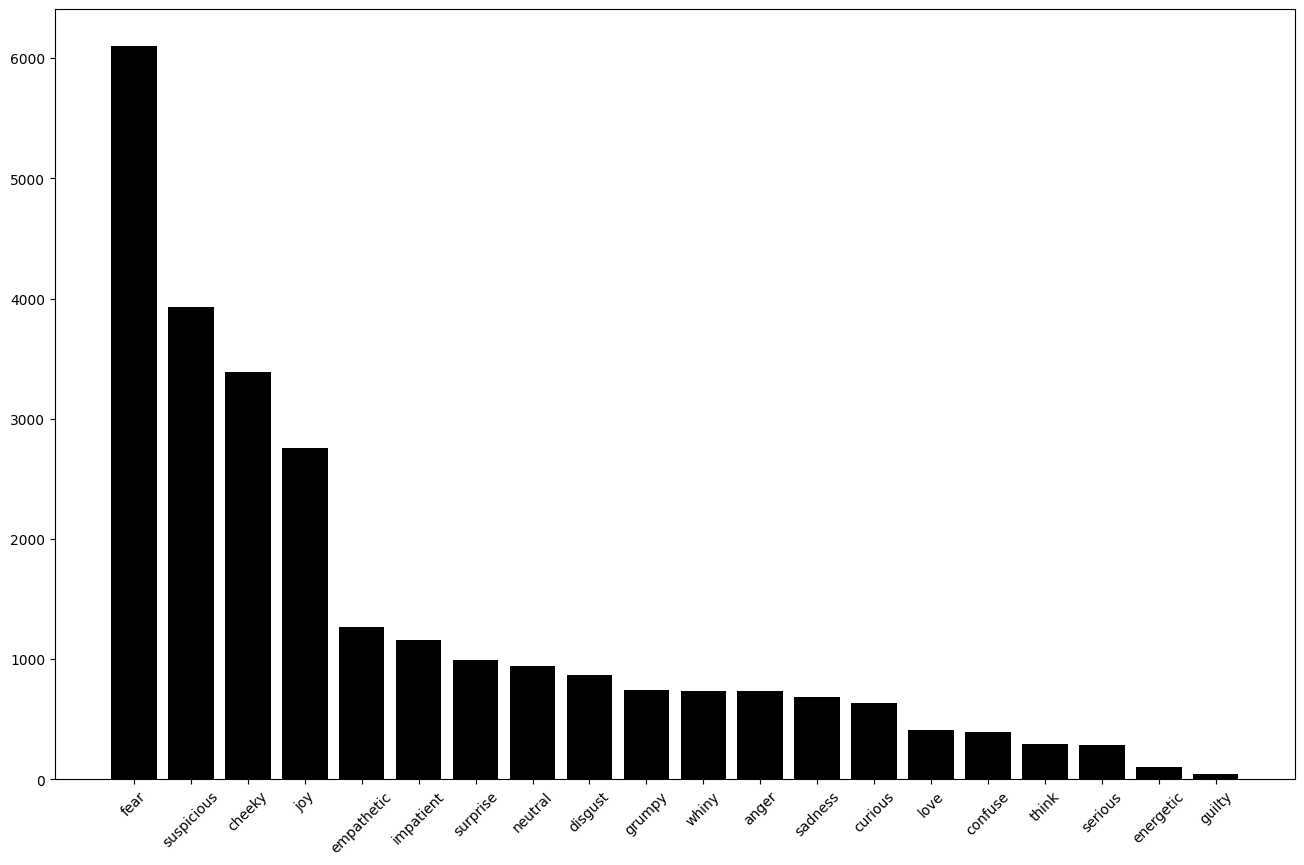

In [125]:
# visualise emotion analysis results
fig = plt.figure(figsize=(16,10))
plt.bar([row[0] for row in sorted_emotions],[row[1] for row in sorted_emotions], color='black')
plt.xticks(rotation = 45)
# plt.savefig('emotions.png')
plt.show()

In [34]:
sentiment_classifier = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')
results_sentiment = []
# start progress visualisation
pbar = tqdm.tqdm(total=len(sents_by_chapter))
for text in sents_by_chapter:
    # predict sentiment of every sentence in set
    prediction = sentiment_classifier(text)
    results_sentiment.append(prediction)
    pbar.update(1)
# close progress visualisation
pbar.close()

C:\Users\mmtom\OneDrive\Pulpit\projects\python\REUTERS_SCRAPER\venv\lib\site-packages\transformers\models\open_llama\modeling_open_llama.py:42: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
100%|██████████| 365/365 [17:17<00:00,  2.84s/it]


In [35]:
# extract sentiment analysis results
results_sentiment = [value['label'] for chapter in results_sentiment for value in chapter]

In [36]:
# visualise sentiment analysis results
sentiment_count = Counter(results_sentiment)
sentiment_count = list(sentiment_count.items())
pd.DataFrame(sentiment_count)

,0,1
0,NEGATIVE,13505
1,POSITIVE,12969
